# Bangla Cyberbullying Classification with Support Vector Classifier

This notebook implements a support vector classifier for multi-class classification of Bangla cyberbullying text.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.preprocessing import label_binarize
from bnlp import SentencepieceTokenizer
from bnlp.embedding.fasttext import BengaliFasttext
from sklearn.preprocessing import LabelEncoder
import time
from itertools import cycle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

warnings.filterwarnings("ignore")

# Set plot style
plt.style.use("ggplot")
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

## 1. Loading and Exploring Datasets

In [4]:
# 1. Load the datasets
print("Loading datasets...")
original_cleaned_df = pd.read_csv("../../dataset/cleaned/original_cleaned.csv")
only_augmented_cleaned_df = pd.read_csv("../../dataset/cleaned/only_augmented.csv")

print(f"Original dataset shape: {original_cleaned_df.shape}")
print(f"Augmented dataset shape: {only_augmented_cleaned_df.shape}")

Loading datasets...
Original dataset shape: (41907, 6)
Augmented dataset shape: (6081, 3)


In [5]:
# Display the first few rows of original dataset
original_cleaned_df.head()

,comment,Category,Gender,comment react number,label,text_length
0,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দি...,Actor,Female,1.0,sexual,128
1,ঘরে শুট কেমন লেগেছে ক্যামেরাতে,Singer,Male,2.0,not bully,30
2,অরে বাবা টা পাগল,Actor,Female,2.0,not bully,16
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully,21
4,পটকা মাছ,Politician,Male,0.0,troll,8


## 2. Label Mapping and Visualization

In [6]:
# Map the labels for both datasets
label_mapping = {"not bully": 0, "troll": 1, "sexual": 2, "religious": 3, "threat": 4}

original_cleaned_df["label_encoded"] = original_cleaned_df["label"].map(label_mapping)
only_augmented_cleaned_df["label_encoded"] = only_augmented_cleaned_df["label"].map(
    label_mapping
)

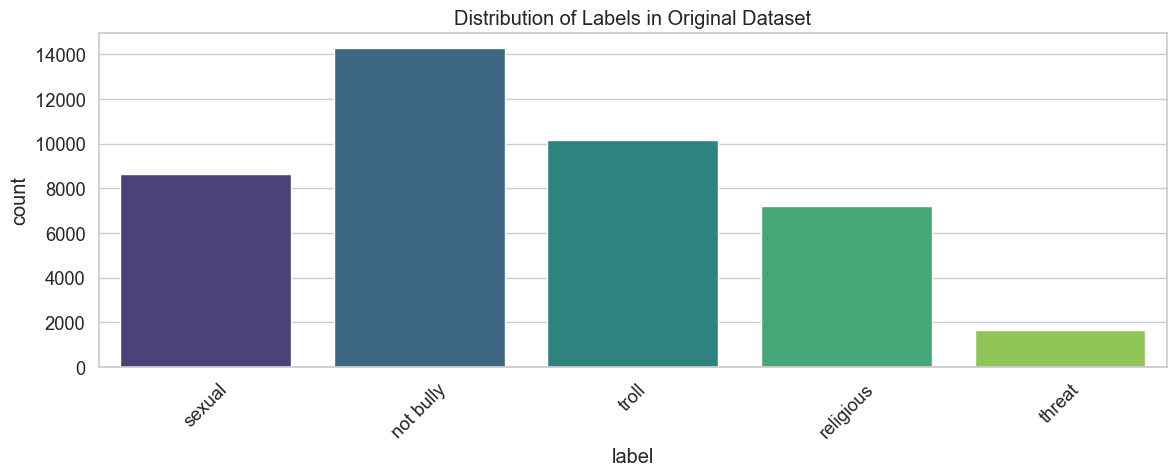

In [7]:
# Check the distribution of labels
plt.figure(figsize=(12, 5))
sns.countplot(x="label", data=original_cleaned_df, palette="viridis")
plt.title("Distribution of Labels in Original Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Data Splitting and Augmentation

In [8]:
# Split the original dataset into train and test sets
X = original_cleaned_df["comment"]
y = original_cleaned_df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size before augmentation: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size before augmentation: 33525
Test set size: 8382


In [9]:
# Add augmented data to the training set
X_aug = only_augmented_cleaned_df["text"]
y_aug = only_augmented_cleaned_df["label_encoded"]

# Concatenate original training data with augmented data
X_train_augmented = pd.concat([X_train, X_aug])
y_train_augmented = pd.concat([y_train, y_aug])

print(f"Training set size after augmentation: {len(X_train_augmented)}")

Training set size after augmentation: 39606


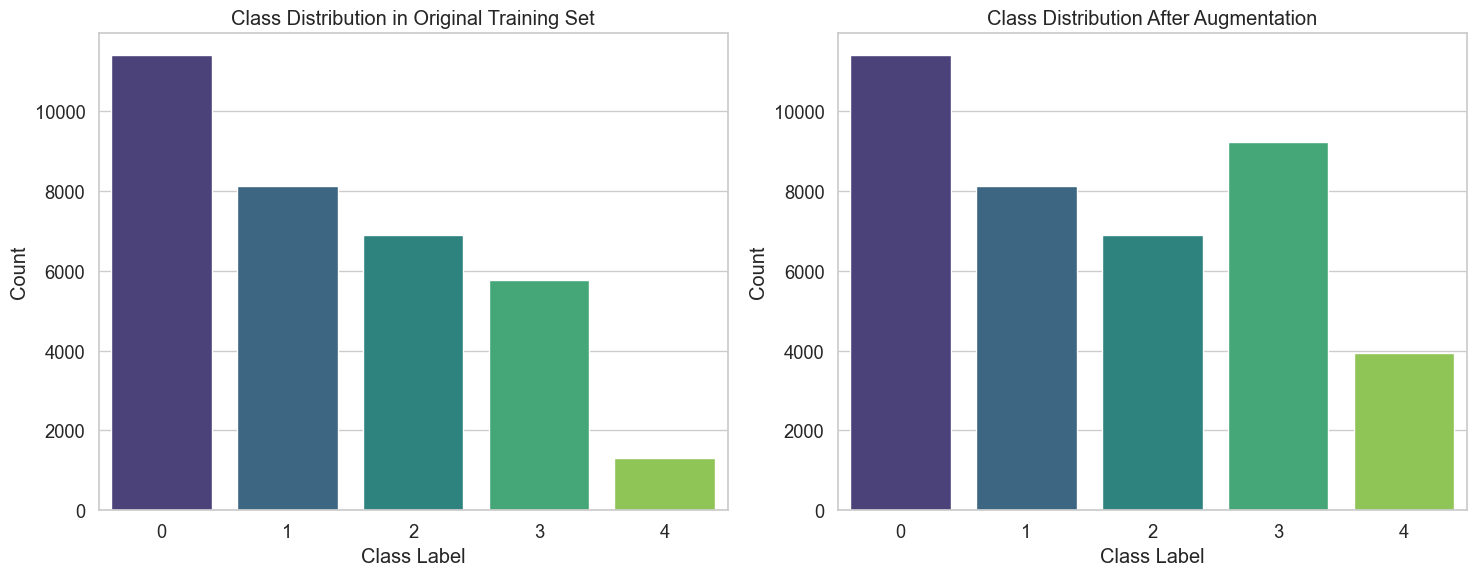

In [10]:
# Visualize the class distribution before and after augmentation
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train, palette="viridis")
plt.title("Class Distribution in Original Training Set")
plt.xlabel("Class Label")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_augmented, palette="viridis")
plt.title("Class Distribution After Augmentation")
plt.xlabel("Class Label")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## 4. Text Tokenization and Vectorization

In [11]:
# Initialize SentencepieceTokenizer and BengaliFasttext
print("Initializing tokenizer and word embedding model...")
sp_tokenizer = SentencepieceTokenizer()
fasttext_model = BengaliFasttext()

Initializing tokenizer and word embedding model...


In [12]:
def tokenize_and_vectorize(text):
    # Tokenize the text
    tokens = sp_tokenizer.tokenize(text)

    # Get vector for each token and average them
    vectors = [
        fasttext_model.get_word_vector(token) for token in tokens if token.strip()
    ]

    # If no valid vectors, return zeros
    if not vectors:
        return np.zeros(300)  # FastText typically uses 300-dimensional vectors

    # Average the vectors
    return np.mean(vectors, axis=0)

In [13]:
# Apply tokenization and vectorization to training data
print("Vectorizing training data...")
start_time = time.time()
X_train_vectors = np.array([tokenize_and_vectorize(text) for text in X_train_augmented])
print(
    f"Training data vectorization completed in {time.time() - start_time:.2f} seconds"
)

Vectorizing training data...
Training data vectorization completed in 9.42 seconds


In [14]:
# Apply tokenization and vectorization to testing data
print("Vectorizing testing data...")
start_time = time.time()
X_test_vectors = np.array([tokenize_and_vectorize(text) for text in X_test])
print(f"Testing data vectorization completed in {time.time() - start_time:.2f} seconds")

Vectorizing testing data...
Testing data vectorization completed in 1.91 seconds


## 5. Training SVC Model

In [15]:
# Configure and train Support Vector Classifier
print("Training Support Vector Classifier model...")
# Parameters optimized for text embeddings
svc_model = SVC(
    C=1.0,              # Regularization parameter
    kernel='rbf',       # Radial basis function kernel
    gamma='scale',      # Kernel coefficient
    decision_function_shape='ovr',  # One-vs-rest approach for multi-class
    class_weight='balanced',  # Handle class imbalance
    probability=True,   # Enable probability estimates
    random_state=42
)

start_time = time.time()
svc_model.fit(X_train_vectors, y_train_augmented)
training_time = time.time() - start_time
print(f"Model trained in {training_time:.2f} seconds")

Training Support Vector Classifier model...
Model trained in 1194.20 seconds


## 6. Model Evaluation - Basic Metrics

In [16]:
# Make predictions and calculate basic metrics
print("Evaluating model...")
y_pred = svc_model.predict(X_test_vectors)

# Calculate basic metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluating model...
Accuracy: 0.6362
Precision: 0.6525
Recall: 0.6362
F1 Score: 0.6406


In [17]:
# Display classification report
print("Classification Report:")
print(
    classification_report(
        y_test,
        y_pred,
        target_names=list(label_mapping.keys()),
        digits=5,
    )
)

Classification Report:
              precision    recall  f1-score   support

   not bully    0.76268   0.67496   0.71615      2852
       troll    0.58724   0.51206   0.54708      2031
      sexual    0.54963   0.60313   0.57514      1726
   religious    0.72856   0.78309   0.75484      1443
      threat    0.30685   0.59697   0.40535       330

    accuracy                        0.63624      8382
   macro avg    0.58699   0.63404   0.59971      8382
weighted avg    0.65248   0.63624   0.64057      8382



## 7. Confusion Matrix Visualization

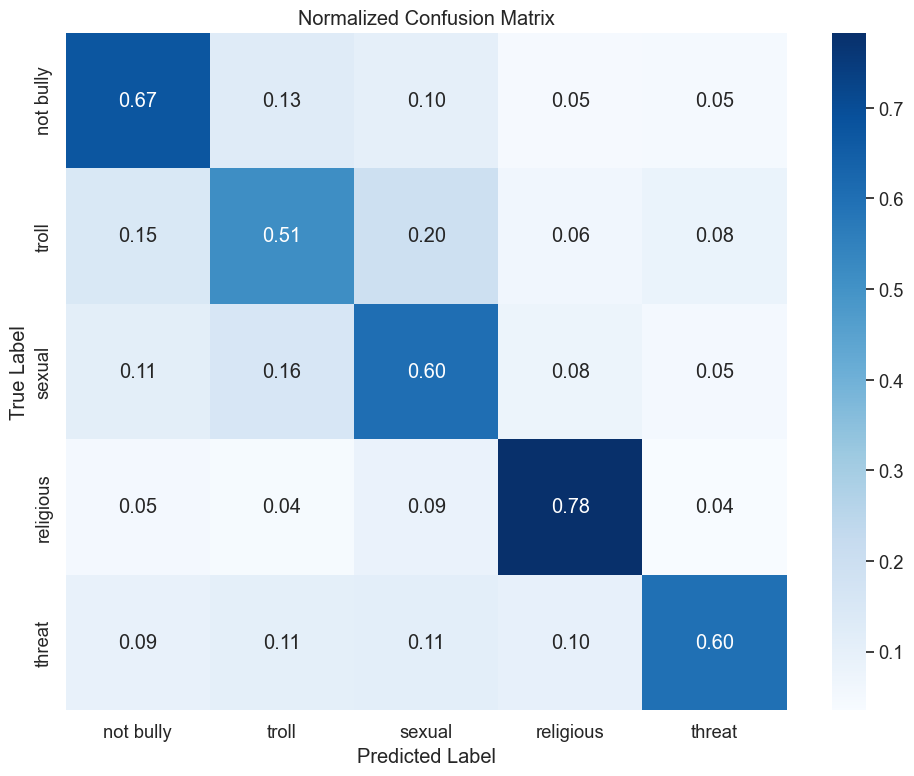

In [18]:
# Create and display confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

## 8. SVC Decision Function Analysis

SVC Model Analysis:
Number of support vectors: [7644 7107 5653 4838 2810]
Total support vectors: 28052
Indices of support vectors: [ 3  5  9 16 22 24 25 27 29 36]...


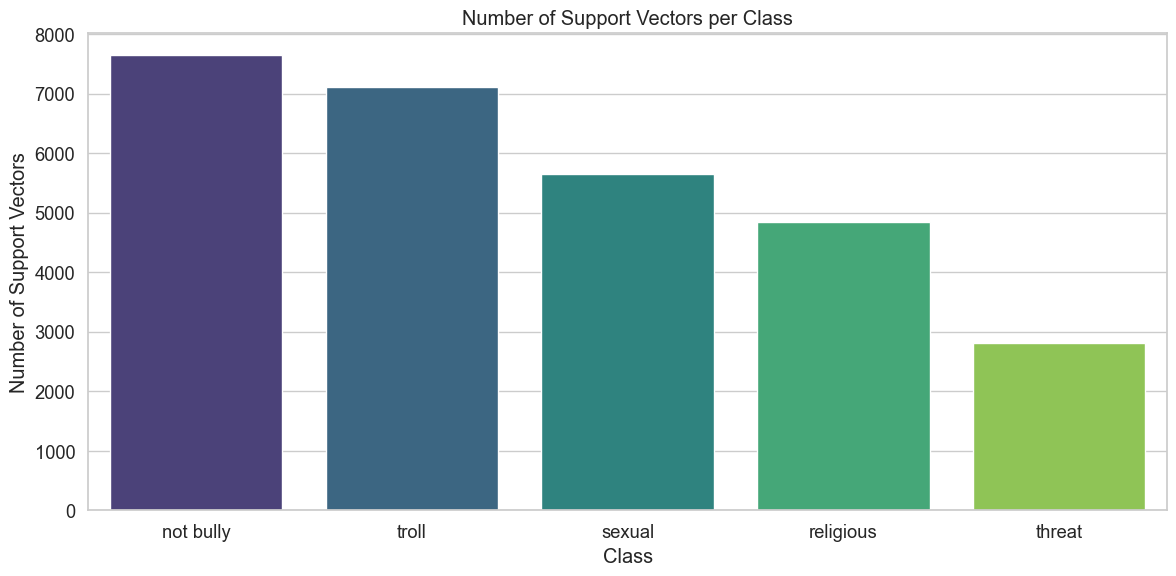

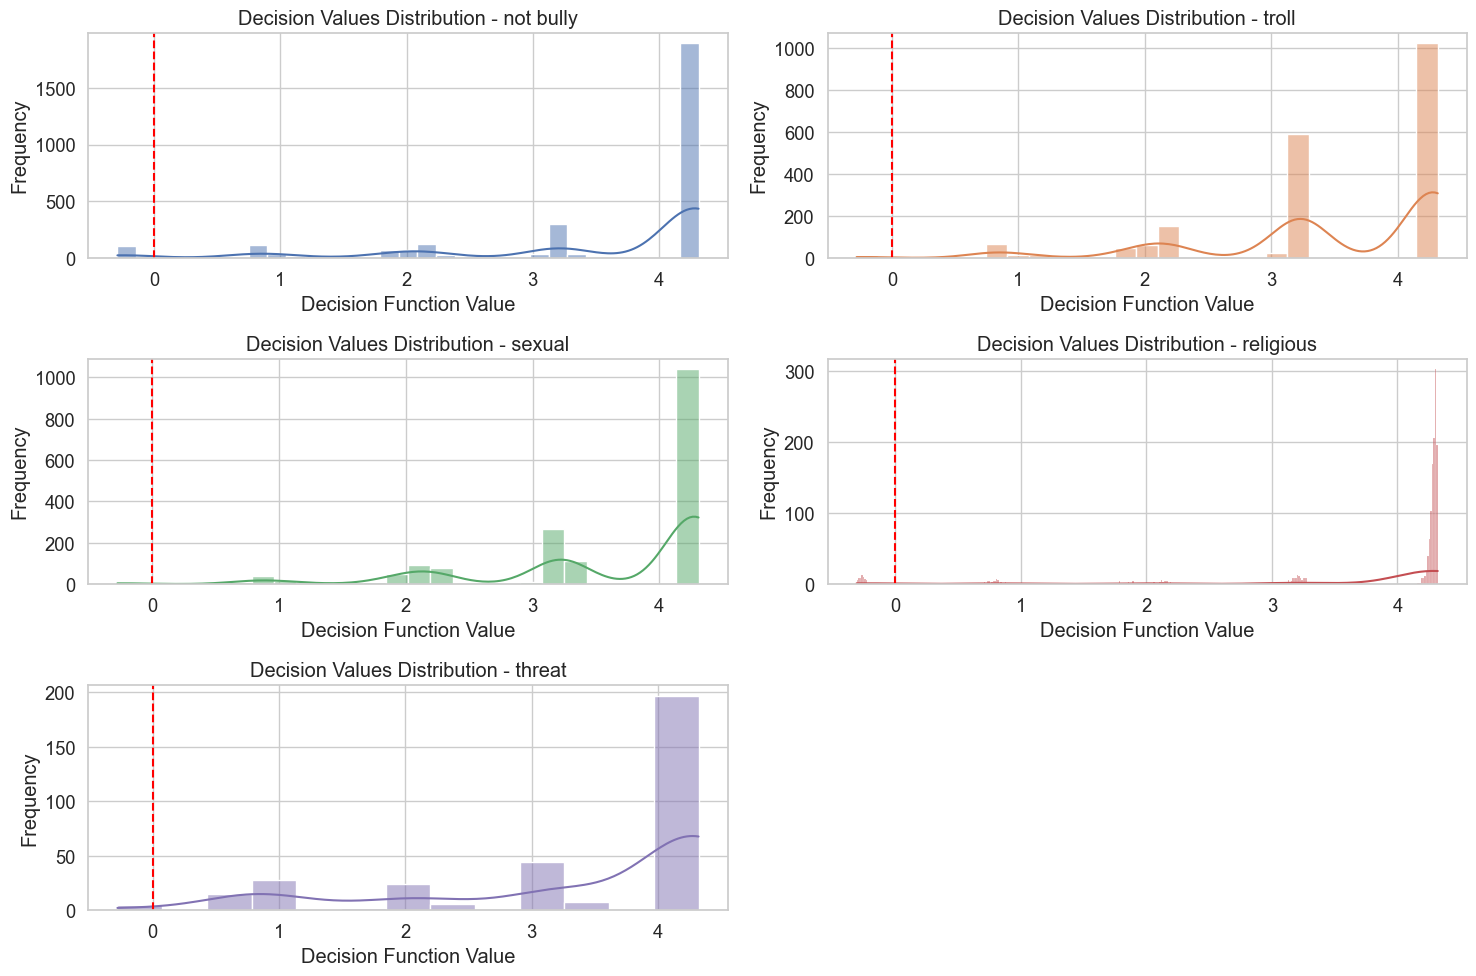

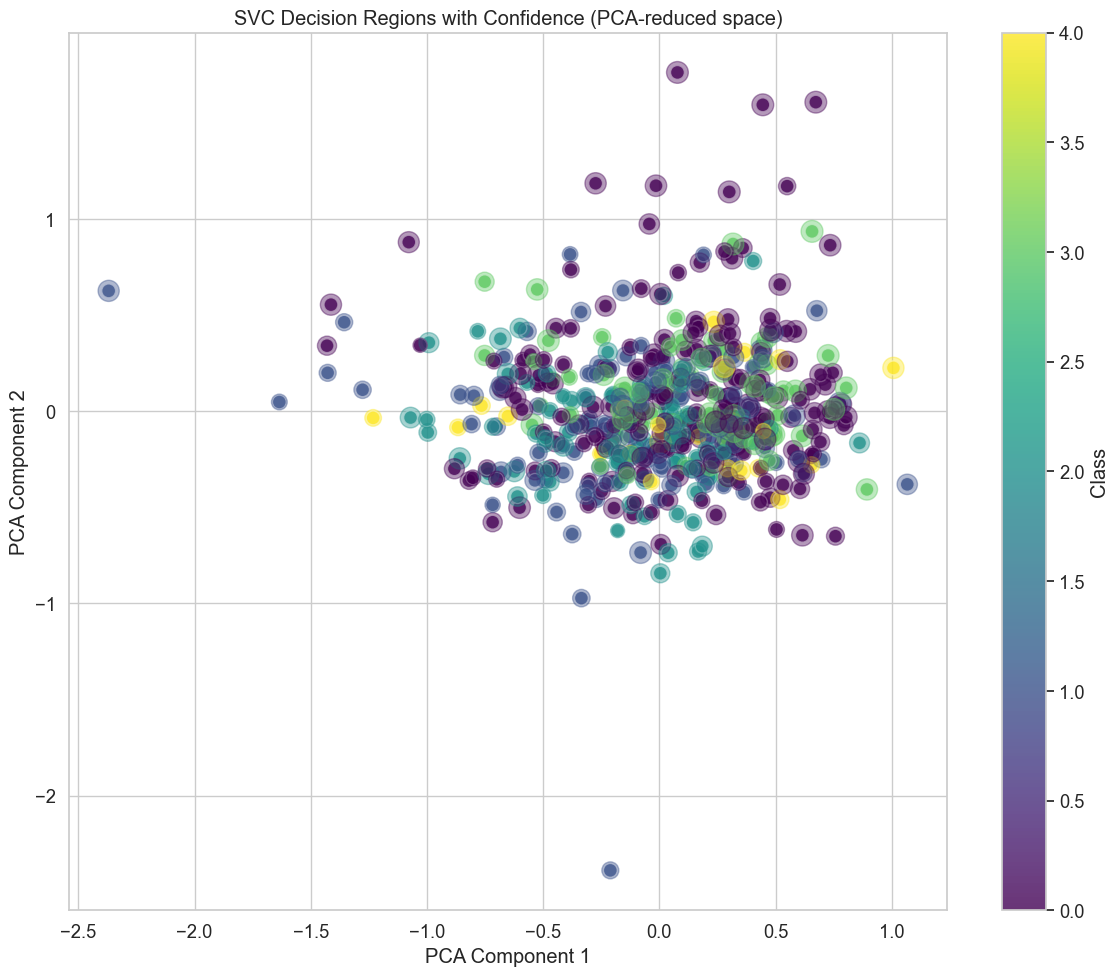

In [19]:
from sklearn.decomposition import PCA

# Analyze SVC model details
print("SVC Model Analysis:")
print(f"Number of support vectors: {svc_model.n_support_}")
print(f"Total support vectors: {sum(svc_model.n_support_)}")
print(f"Indices of support vectors: {svc_model.support_[:10]}...")

# Plot support vector counts by class
classes = list(label_mapping.keys())
plt.figure(figsize=(12, 6))
sns.barplot(x=classes, y=svc_model.n_support_, palette="viridis")
plt.title("Number of Support Vectors per Class")
plt.xlabel("Class")
plt.ylabel("Number of Support Vectors")
plt.tight_layout()
plt.show()

# Decision function analysis
# Get decision function values for all samples
decision_values = svc_model.decision_function(X_test_vectors)

# Visualize decision function distributions for each class
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes):
    # Get indices of samples in this class
    class_indices = np.where(y_test == i)[0]

    # Get decision values for this class (one-vs-rest approach)
    if decision_values.ndim > 1:  # Multi-class case
        class_decisions = decision_values[class_indices, i]
    else:  # Binary case
        class_decisions = decision_values[class_indices]

    plt.subplot(3, 2, i + 1)
    sns.histplot(class_decisions, kde=True, color=f"C{i}")
    plt.axvline(x=0, color="red", linestyle="--")
    plt.title(f"Decision Values Distribution - {class_name}")
    plt.xlabel("Decision Function Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Visualize decision boundary confidence
# Take a sample of test points for visualization clarity
sample_size = min(500, len(X_test))
sampled_indices = np.random.choice(len(X_test), sample_size, replace=False)
X_sampled = X_test_vectors[sampled_indices]
y_sampled = y_test.iloc[sampled_indices].values

# Use PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sampled)

# Plot decision regions with confidence
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y_sampled,
    cmap="viridis",
    alpha=0.8,
    edgecolors="w",
    s=100,
)

# Add confidence levels represented by marker size
conf_scores = np.max(svc_model.predict_proba(X_sampled), axis=1)
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y_sampled,
    cmap="viridis",
    alpha=0.4,
    s=conf_scores * 200 + 50,
)

plt.colorbar(scatter, label="Class")
plt.title("SVC Decision Regions with Confidence (PCA-reduced space)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()

## 9. ROC Curve Analysis

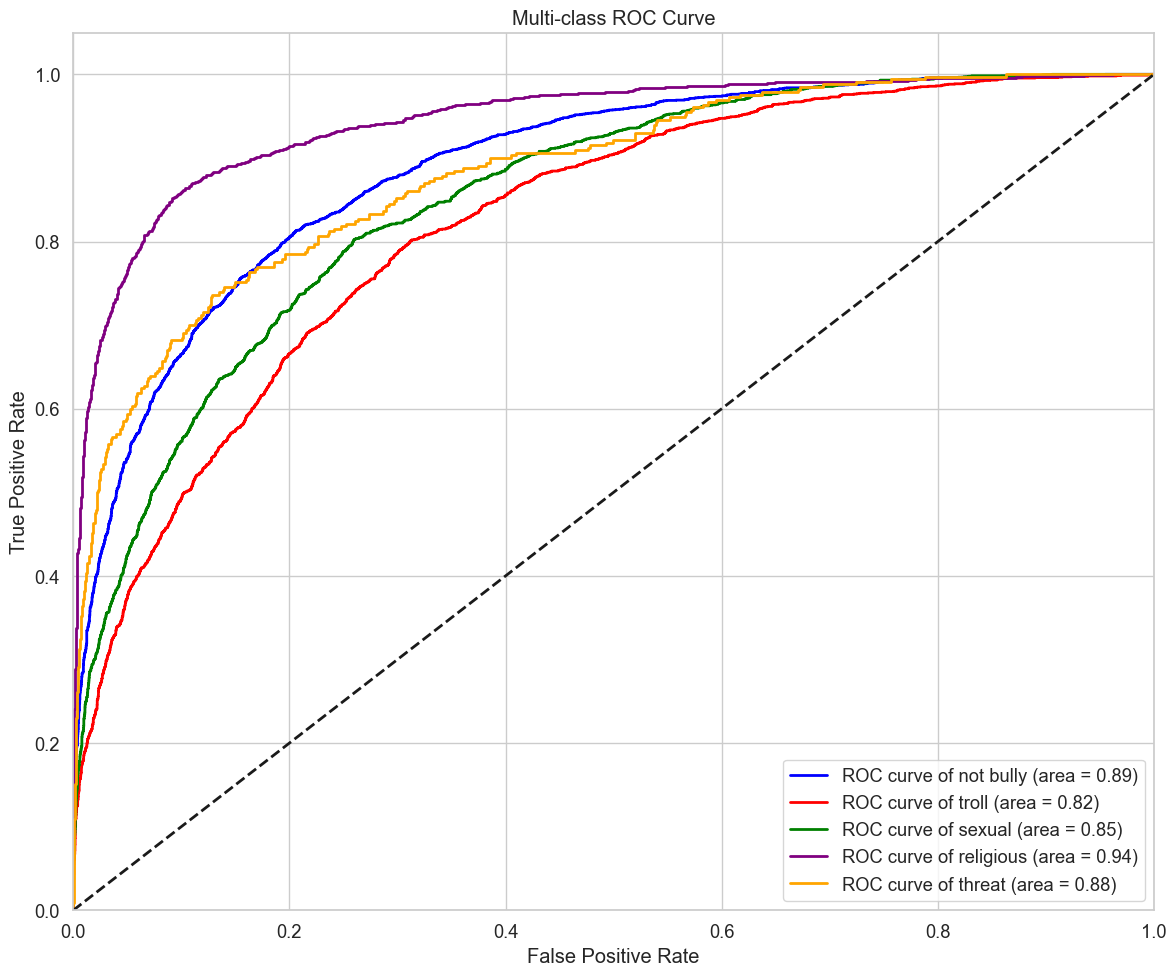

In [20]:
# ROC Curve and AUC for each class
# Binarize the output for ROC curve
y_test_bin = label_binarize(y_test, classes=range(5))
y_score = svc_model.predict_proba(X_test_vectors)

# Calculate ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(12, 10))
colors = cycle(["blue", "red", "green", "purple", "orange"])
class_names = list(label_mapping.keys())

for i, color, class_name in zip(range(5), colors, class_names):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f"ROC curve of {class_name} (area = {roc_auc[i]:.2f})",
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 10. Precision-Recall Curve Analysis

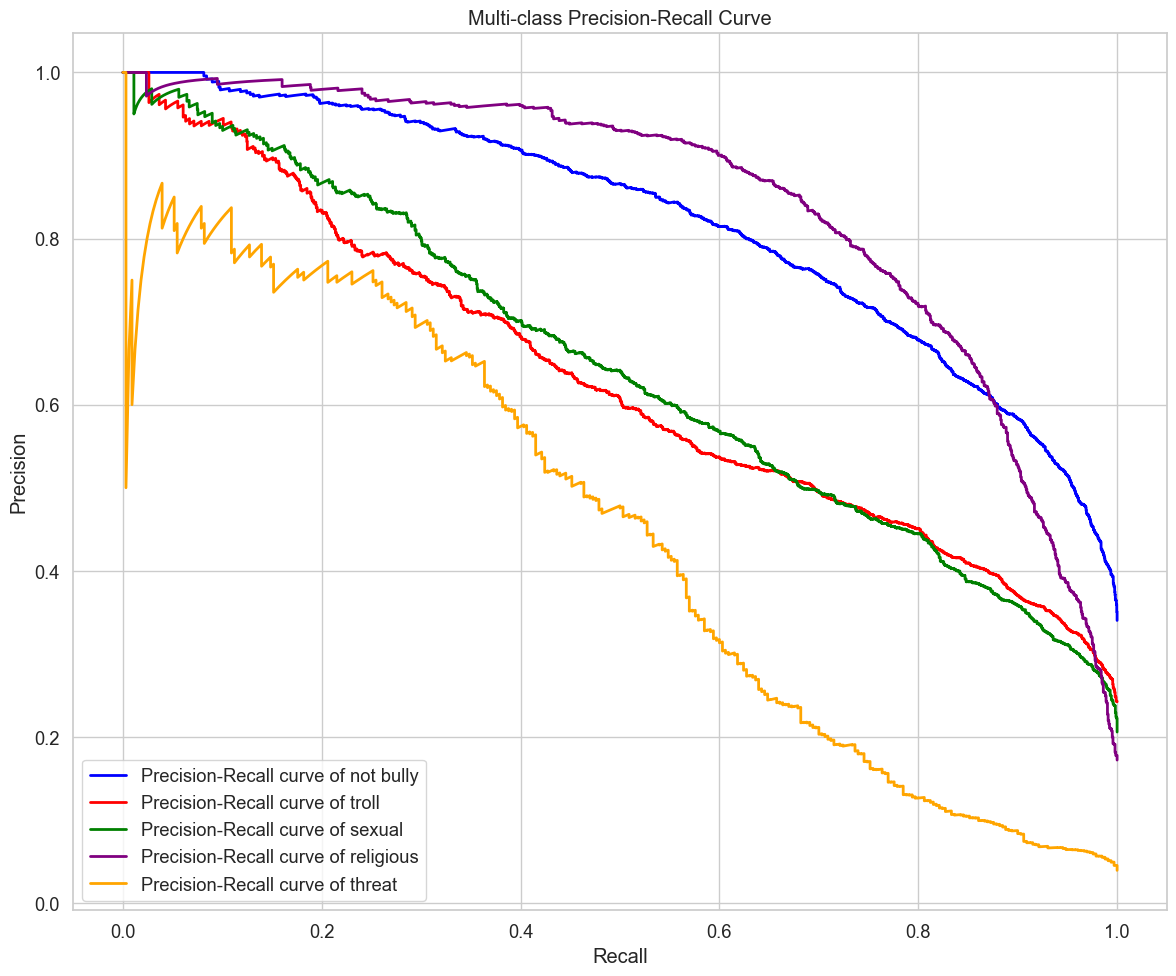

In [21]:
# Calculate Precision-Recall curve and average precision for each class
precision = {}
recall = {}
plt.figure(figsize=(12, 10))

for i, color, class_name in zip(range(5), colors, class_names):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(
        recall[i],
        precision[i],
        color=color,
        lw=2,
        label=f"Precision-Recall curve of {class_name}",
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class Precision-Recall Curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

## 11. Model Summary and Saving

In [22]:
# Summary of the model
print("Model Summary:")
print(f"Total samples in training set (with augmentation): {len(X_train_augmented)}")
print(f"Total samples in test set: {len(X_test)}")
print(f"Number of features (vector dimension): {X_train_vectors.shape[1]}")
print(f"Final model accuracy on test set: {accuracy:.4f}")
print(f"Training time: {training_time:.2f} seconds")

Model Summary:
Total samples in training set (with augmentation): 39606
Total samples in test set: 8382
Number of features (vector dimension): 100
Final model accuracy on test set: 0.6362
Training time: 1194.20 seconds


In [23]:
# Save the model if needed
import joblib
joblib.dump(svc_model, "../../models/svc/multiclass_svc.pkl")

['../../models/svc/multiclass_svc.pkl']